In [1]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload
import time
import tqdm 

import scipy.stats
import math

In [2]:
# Importing data:
path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_adapbox_rsl.fits'))[1].data

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint_1'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

freqs = np.load('MKT_Freqs_mid.npy')

lamb = c.value/freqs

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')
sources_phi = np.load(savedir+'Abell85_phi.npy')
mask = np.load(r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'+'Abell85_mask_5sigma10pix.npy')

I_select = flux_measurements_I[:,mask]
Q_select = flux_measurements_Q[:,mask]
U_select = flux_measurements_U[:,mask]
I_unc_select = flux_unc_I[:,mask]
Q_unc_select = flux_unc_Q[:,mask]
U_unc_select = flux_unc_U[:,mask]
phi_select = sources_phi[mask]
rsl_select = rsl[mask]

angles_select = 0.5*np.arctan2(U_select, Q_select)
angles_select_err = np.sqrt((Q_select*U_unc_select)**2 + (U_select*Q_unc_select)**2)/(2*(U_select**2 + Q_select**2))
linpol_select = np.sqrt(U_select**2 + Q_select**2)
linpol_select_err = (U_select*U_unc_select + Q_select*Q_unc_select)/linpol_select
p_select = linpol_select/I_select
p_select_err = p_select*np.sqrt((0*linpol_select_err/linpol_select)**2 + (I_unc_select/I_select)**2)

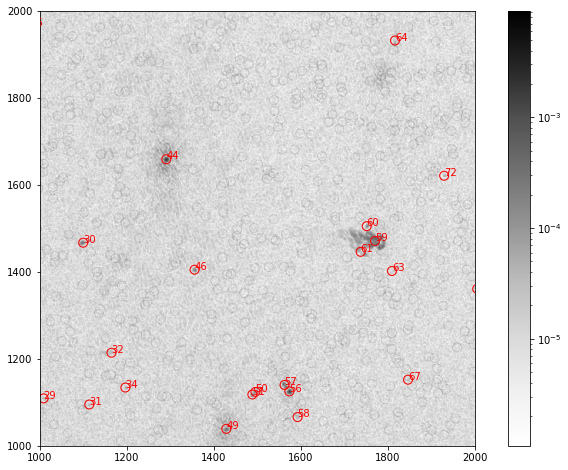

In [3]:
# Selecting the five sources that Erik Osinga also investigated as check:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)
plt.figure(figsize=(12,8))
a = plt.imshow(data_polint.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[mask,0], sources_pixpos[mask,1], s=80, facecolors='none', edgecolors='r')
for n in range(len(sources_pixpos[mask,0])):
    plt.text(sources_pixpos[mask,0][n], sources_pixpos[mask,1][n], str(n), color='red', clip_on=True)
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

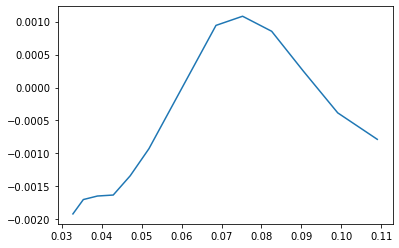

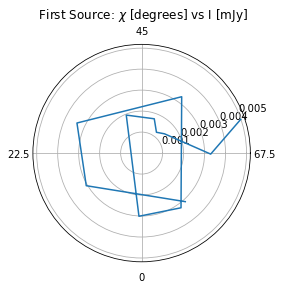

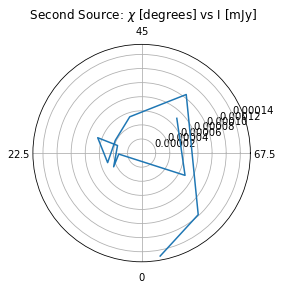

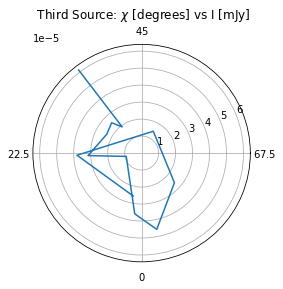

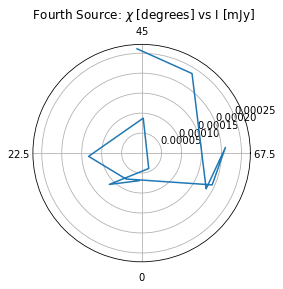

In [4]:
plt.plot(lamb**2, Q_select[:,44])
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,44], linpol_select[:,37])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" First Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,46], linpol_select[:,38])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Second Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,56], linpol_select[:,45])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Third Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,57], linpol_select[:,46])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Fourth Source: $\chi$ [degrees] vs I [mJy]")
plt.show()



In [5]:
#So, we need the sources 44, 46, 56, 57:
mask_erik = np.zeros(len(I_select[0]), dtype=bool)
mask_erik[44]=True
mask_erik[46]=True
mask_erik[56]=True
mask_erik[57]=True

I_compar = I_select[:,mask_erik]
Q_compar = Q_select[:,mask_erik]
U_compar = U_select[:,mask_erik]
I_unc_compar = I_unc_select[:,mask_erik]
Q_unc_compar = Q_unc_select[:,mask_erik]
U_unc_compar = U_unc_select[:,mask_erik]
phi_compar = phi_select[mask_erik]
rsl_compar = rsl_select[mask_erik]

angles_compar = angles_select[:,mask_erik]
angles_compar_err = angles_select_err[:,mask_erik]
linpol_compar = linpol_select[:,mask_erik]
linpol_compar_err = linpol_select_err[:,mask_erik]
p_compar = p_select[:,mask_erik]
p_compar_err = p_select_err[:,mask_erik]

print(len(mask_erik))

132


# Using Faraday MCMC functions script:

60.0
(160000, 4)
Saving chain to /net/vdesk/data2/GoesaertW/Meerkat_Data/Achain_source_0_QU.npy
0.037175261893989925 33.28054790176542
The time of execution of above program is : 18.601887464523315


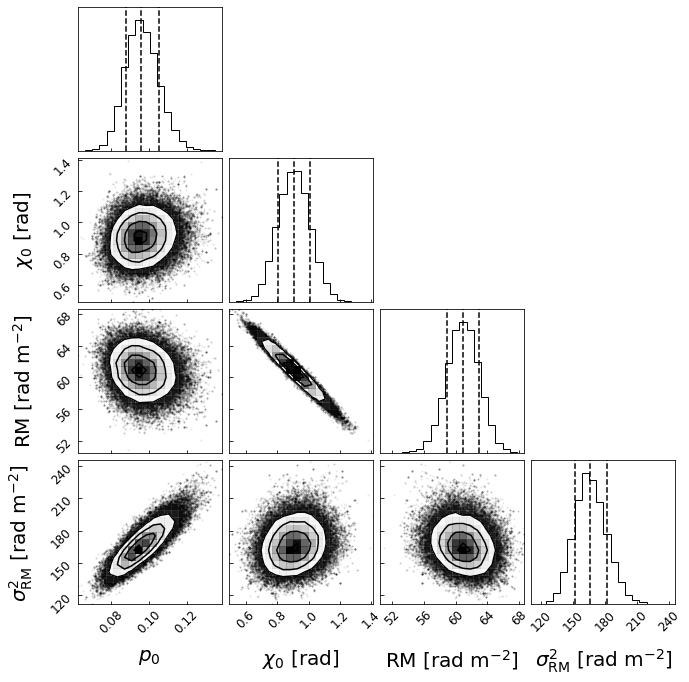

In [25]:
reload(mcmc)
reload(mcmc_plots)
start = time.time()

#We will look at one of the 4 sources:
source=1
print(phi_compar[source])
fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, I_compar[:,source], I_unc_compar[:,source]\
                        , Q_compar[:,source], Q_unc_compar[:,source], U_compar[:,source], U_unc_compar[:,source]\
                        , phi_compar[source], rsl_compar[source]['RA'], rsl_compar[source]['DEC'], cornerplot=True,curvature=True\
                        ,sourcenum=0)
reduced_chi2 = mcmc_plots.models('ExtDepol', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], I_compar[:,source]\
                , I_unc_compar[:,source], Q_compar[:,source], Q_unc_compar[:,source], U_compar[:,source], U_unc_compar[:,source])
reduced_chi2_i = reduced_chi2[3]
reduced_chi2_qu = reduced_chi2[4]
print(reduced_chi2_i, reduced_chi2_qu)

end = time.time()
print("The time of execution of above program is :", end-start)

0.09641159181355571 0.9065473618992976 60.876942039784566 12.910050461589938


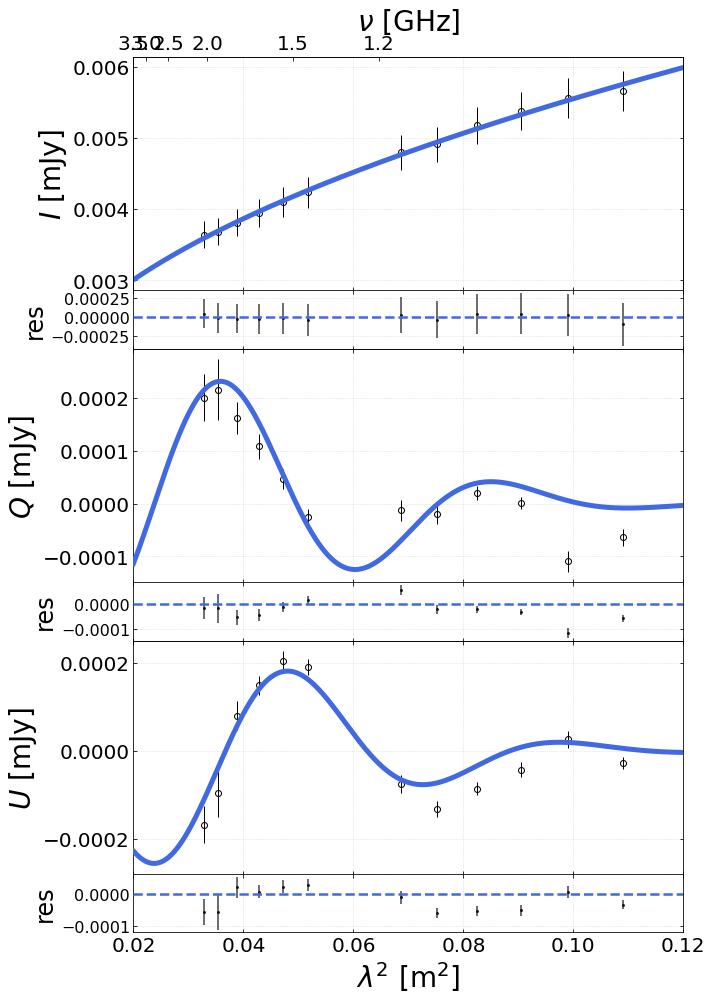

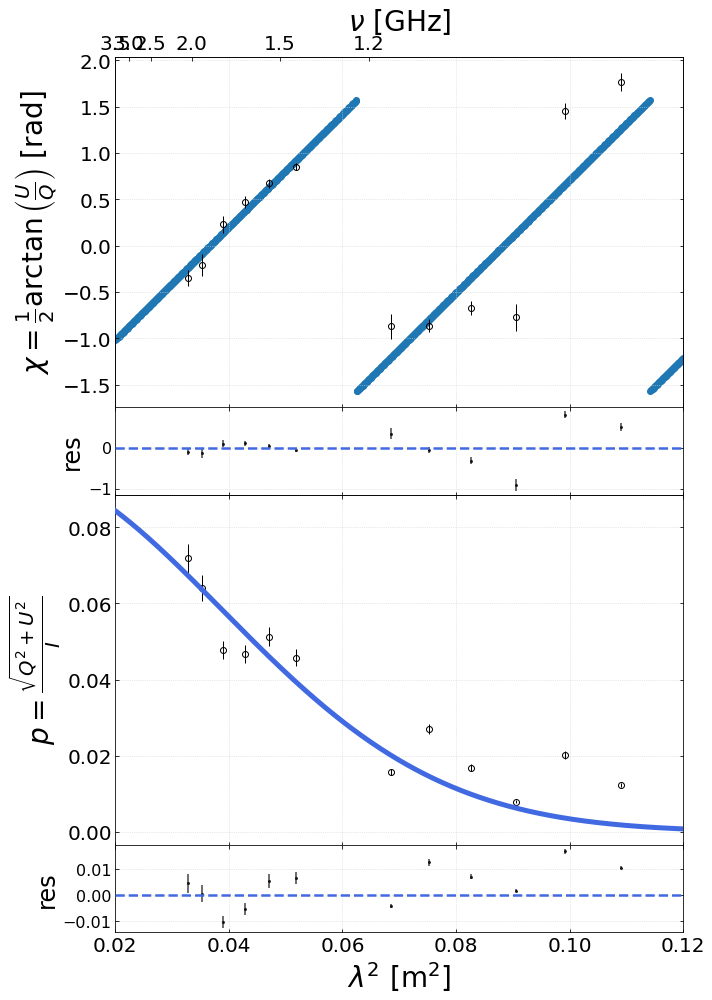

In [12]:
reload(mcmc_plots)
print(fit_data[0][1], fit_data[1][1], fit_data[2][1], np.sqrt(fit_data[3][1]))
mcmc_plots.plots('ExtDepol', 'depolfit_test', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1], fit_data[0][1]\
            , fit_data[1][1], fit_data[2][1], np.sqrt(fit_data[3][1]), I_compar[:,source], I_unc_compar[:,source]\
            , Q_compar[:,source], Q_unc_compar[:,source], U_compar[:,source], U_unc_compar[:,source]\
            , angles_compar[:,source], angles_compar_err[:,source], p_compar[:,source]\
            , p_compar_err[:,source], xlim=[0.02, 0.12], imgformat="pdf",saveplot=True)

# Repeat for all sources:

In [26]:
selectnum = len(rsl_select)
print(selectnum)
redchisq_I_list = np.zeros(selectnum)
redchisq_QU_list = np.zeros(selectnum)

norm_list = np.zeros((selectnum,3))
spix_list = np.zeros((selectnum,3))
curv_list = np.zeros((selectnum,3))
p0_list = np.zeros((selectnum,3))
chi0_list = np.zeros((selectnum,3))
RM_list = np.zeros((selectnum,3))
sigma_list = np.zeros((selectnum,3))

132


In [27]:
reload(mcmc)
reload(mcmc_plots)

for n in tqdm.tqdm(range(selectnum)):
    fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, I_select[:,n], I_unc_select[:,n]\
                        , Q_select[:,n], Q_unc_select[:,n], U_select[:,n], U_unc_select[:,n]\
                        , phi_select[n], rsl_select[n]['RA'], rsl_select[n]['DEC'], cornerplot=False,curvature=True\
                        , sourcenum=0)
    redchisq = mcmc_plots.models('ExtDepol', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], I_select[:,n]\
                , I_unc_select[:,n], Q_select[:,n], Q_unc_select[:,n], U_select[:,n], U_unc_select[:,n])

    redchisq_I_list[n] = redchisq[3]
    redchisq_QU_list[n] = redchisq[4]

    norm_list[n] = fit_dataI[0][1:]
    spix_list[n] = fit_dataI[1][1:]
    curv_list[n] = fit_dataI[2][1:]
    
    p0_list[n] = fit_data[0][1:]
    chi0_list[n] = fit_data[1][1:]
    RM_list[n] = fit_data[2][1:]
    sigma_list[n] = fit_data[3][1:]

directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
np.save(directory+'Abell85_mcmc_Inorm_chi01p7.npy', norm_list)
np.save(directory+'Abell85_mcmc_Ispix_chi01p7.npy', spix_list)
np.save(directory+'Abell85_mcmc_Icurv_chi01p7.npy', curv_list)
np.save(directory+'Abell85_mcmc_p0_chi01p7.npy', p0_list)
np.save(directory+'Abell85_mcmc_chi0_chi01p7.npy', chi0_list)
np.save(directory+'Abell85_mcmc_RM_chi01p7.npy', RM_list)
np.save(directory+'Abell85_mcmc_sigma_chi01p7.npy', sigma_list)
np.save(directory+'Abell85_mcmc_QUchisqw_chi01p7.npy', redchisq_QU_list)
np.save(directory+'Abell85_mcmc_Ichisqw_chi01p7.npy', redchisq_I_list)

  1%|          | 1/132 [00:13<30:17, 13.87s/it]

(160000, 4)


  2%|▏         | 2/132 [00:28<30:43, 14.18s/it]

(160000, 4)


  2%|▏         | 3/132 [00:42<30:08, 14.02s/it]

(160000, 4)


  3%|▎         | 4/132 [00:57<31:14, 14.64s/it]

(160000, 4)


  4%|▍         | 5/132 [01:11<30:33, 14.44s/it]

(160000, 4)


  5%|▍         | 6/132 [01:25<30:01, 14.30s/it]

(160000, 4)


  5%|▌         | 7/132 [01:32<24:28, 11.75s/it]

(160000, 4)


  6%|▌         | 8/132 [01:44<24:28, 11.84s/it]

(160000, 4)


  7%|▋         | 9/132 [01:59<26:14, 12.80s/it]

(160000, 4)


  8%|▊         | 10/132 [02:11<25:33, 12.57s/it]

(160000, 4)


  8%|▊         | 11/132 [02:22<24:19, 12.06s/it]

(160000, 4)


  9%|▉         | 12/132 [02:36<25:21, 12.68s/it]

(160000, 4)


 10%|▉         | 13/132 [02:49<25:41, 12.96s/it]

(160000, 4)


 11%|█         | 14/132 [03:01<24:40, 12.55s/it]

(160000, 4)


 11%|█▏        | 15/132 [03:15<25:22, 13.01s/it]

(160000, 4)


 12%|█▏        | 16/132 [03:27<24:14, 12.54s/it]

(160000, 4)


 13%|█▎        | 17/132 [03:41<25:13, 13.16s/it]

(160000, 4)


 14%|█▎        | 18/132 [03:56<25:52, 13.62s/it]

(160000, 4)


 14%|█▍        | 19/132 [04:09<25:34, 13.58s/it]

(160000, 4)


 15%|█▌        | 20/132 [04:23<25:35, 13.71s/it]

(160000, 4)


 16%|█▌        | 21/132 [04:37<25:29, 13.78s/it]

(160000, 4)


 17%|█▋        | 22/132 [04:49<24:01, 13.11s/it]

(160000, 4)


 17%|█▋        | 23/132 [05:02<23:52, 13.14s/it]

(160000, 4)


 18%|█▊        | 24/132 [05:14<22:50, 12.69s/it]

(160000, 4)


 19%|█▉        | 25/132 [05:27<23:02, 12.92s/it]

(160000, 4)


 20%|█▉        | 26/132 [05:42<23:45, 13.45s/it]

(160000, 4)


 20%|██        | 27/132 [05:56<24:08, 13.79s/it]

(160000, 4)


 21%|██        | 28/132 [06:11<24:13, 13.97s/it]

(160000, 4)


 22%|██▏       | 29/132 [06:24<23:43, 13.82s/it]

(160000, 4)


 23%|██▎       | 30/132 [06:36<22:41, 13.35s/it]

(160000, 4)


 23%|██▎       | 31/132 [06:51<23:03, 13.70s/it]

(160000, 4)


 24%|██▍       | 32/132 [07:03<21:46, 13.07s/it]

(160000, 4)


 25%|██▌       | 33/132 [07:16<21:55, 13.29s/it]

(160000, 4)


 26%|██▌       | 34/132 [07:29<21:18, 13.05s/it]

(160000, 4)


 27%|██▋       | 35/132 [07:42<21:07, 13.07s/it]

(160000, 4)


 27%|██▋       | 36/132 [07:56<21:32, 13.47s/it]

(160000, 4)


 28%|██▊       | 37/132 [08:11<21:50, 13.80s/it]

(160000, 4)


 29%|██▉       | 38/132 [08:25<21:30, 13.72s/it]

(160000, 4)


 30%|██▉       | 39/132 [08:38<21:06, 13.62s/it]

(160000, 4)


 30%|███       | 40/132 [08:52<21:19, 13.91s/it]

(160000, 4)


 31%|███       | 41/132 [09:06<20:57, 13.81s/it]

(160000, 4)


 32%|███▏      | 42/132 [09:18<19:48, 13.21s/it]

(160000, 4)


 33%|███▎      | 43/132 [09:33<20:13, 13.64s/it]

(160000, 4)


 33%|███▎      | 44/132 [09:44<19:11, 13.08s/it]

(160000, 4)


 34%|███▍      | 45/132 [10:00<19:56, 13.75s/it]

(160000, 4)


 35%|███▍      | 46/132 [10:12<19:13, 13.41s/it]

(160000, 4)


 36%|███▌      | 47/132 [10:29<20:14, 14.29s/it]

(160000, 4)


 36%|███▋      | 48/132 [10:43<19:57, 14.25s/it]

(160000, 4)


 37%|███▋      | 49/132 [10:56<19:17, 13.94s/it]

(160000, 4)


 38%|███▊      | 50/132 [11:10<18:56, 13.86s/it]

(160000, 4)


 39%|███▊      | 51/132 [11:24<18:51, 13.97s/it]

(160000, 4)


 39%|███▉      | 52/132 [11:38<18:38, 13.99s/it]

(160000, 4)


 40%|████      | 53/132 [11:50<17:53, 13.59s/it]

(160000, 4)


 41%|████      | 54/132 [12:05<17:51, 13.74s/it]

(160000, 4)


 42%|████▏     | 55/132 [12:16<16:47, 13.08s/it]

(160000, 4)


 42%|████▏     | 56/132 [12:30<16:49, 13.29s/it]

(160000, 4)


 43%|████▎     | 57/132 [12:44<16:59, 13.59s/it]

(160000, 4)


 44%|████▍     | 58/132 [12:58<16:53, 13.70s/it]

(160000, 4)


 45%|████▍     | 59/132 [13:13<16:55, 13.92s/it]

(160000, 4)


 45%|████▌     | 60/132 [13:27<16:54, 14.09s/it]

(160000, 4)


 46%|████▌     | 61/132 [13:42<16:48, 14.20s/it]

(160000, 4)


 47%|████▋     | 62/132 [13:53<15:33, 13.34s/it]

(160000, 4)


 48%|████▊     | 63/132 [14:06<15:09, 13.18s/it]

(160000, 4)


 48%|████▊     | 64/132 [14:17<14:22, 12.69s/it]

(160000, 4)


 49%|████▉     | 65/132 [14:30<14:11, 12.71s/it]

(160000, 4)


 50%|█████     | 66/132 [14:43<14:10, 12.89s/it]

(160000, 4)


 51%|█████     | 67/132 [14:58<14:30, 13.39s/it]

(160000, 4)


 52%|█████▏    | 68/132 [15:09<13:42, 12.85s/it]

(160000, 4)


 52%|█████▏    | 69/132 [15:23<13:42, 13.05s/it]

(160000, 4)


 53%|█████▎    | 70/132 [15:37<13:43, 13.28s/it]

(160000, 4)


 54%|█████▍    | 71/132 [15:48<13:01, 12.81s/it]

(160000, 4)


 55%|█████▍    | 72/132 [16:00<12:26, 12.44s/it]

(160000, 4)


 55%|█████▌    | 73/132 [16:14<12:39, 12.87s/it]

(160000, 4)


 56%|█████▌    | 74/132 [16:28<12:55, 13.36s/it]

(160000, 4)


 57%|█████▋    | 75/132 [16:43<12:55, 13.60s/it]

(160000, 4)


 58%|█████▊    | 76/132 [16:57<12:53, 13.81s/it]

(160000, 4)


 58%|█████▊    | 77/132 [17:11<12:38, 13.79s/it]

(160000, 4)


 59%|█████▉    | 78/132 [17:23<12:08, 13.49s/it]

(160000, 4)


 60%|█████▉    | 79/132 [17:36<11:48, 13.36s/it]

(160000, 4)


 61%|██████    | 80/132 [17:51<11:50, 13.66s/it]

(160000, 4)


 61%|██████▏   | 81/132 [18:05<11:48, 13.89s/it]

(160000, 4)


 62%|██████▏   | 82/132 [18:19<11:34, 13.89s/it]

(160000, 4)


 63%|██████▎   | 83/132 [18:24<09:13, 11.29s/it]

(160000, 4)


 64%|██████▎   | 84/132 [18:39<09:46, 12.22s/it]

(160000, 4)


 64%|██████▍   | 85/132 [18:52<09:49, 12.55s/it]

(160000, 4)


 65%|██████▌   | 86/132 [19:06<09:52, 12.89s/it]

(160000, 4)


 66%|██████▌   | 87/132 [19:17<09:21, 12.47s/it]

(160000, 4)


 67%|██████▋   | 88/132 [19:31<09:22, 12.79s/it]

(160000, 4)


 67%|██████▋   | 89/132 [19:45<09:27, 13.19s/it]

(160000, 4)


 68%|██████▊   | 90/132 [19:58<09:18, 13.30s/it]

(160000, 4)


 69%|██████▉   | 91/132 [20:12<09:06, 13.32s/it]

(160000, 4)


 70%|██████▉   | 92/132 [20:26<09:07, 13.68s/it]

(160000, 4)


 70%|███████   | 93/132 [20:40<08:53, 13.68s/it]

(160000, 4)


 71%|███████   | 94/132 [20:54<08:47, 13.88s/it]

(160000, 4)


 72%|███████▏  | 95/132 [21:09<08:39, 14.05s/it]

(160000, 4)


 73%|███████▎  | 96/132 [21:22<08:17, 13.82s/it]

(160000, 4)


 73%|███████▎  | 97/132 [21:36<08:09, 13.98s/it]

(160000, 4)


 74%|███████▍  | 98/132 [21:50<07:50, 13.84s/it]

(160000, 4)


 75%|███████▌  | 99/132 [22:03<07:29, 13.61s/it]

(160000, 4)


/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
 76%|███████▌  | 100/132 [22:16<07:08, 13.40s/it]

(160000, 4)


 77%|███████▋  | 101/132 [22:31<07:06, 13.75s/it]

(160000, 4)


 77%|███████▋  | 102/132 [22:45<06:55, 13.84s/it]

(160000, 4)


 78%|███████▊  | 103/132 [22:57<06:25, 13.29s/it]

(160000, 4)


 79%|███████▉  | 104/132 [23:08<05:58, 12.81s/it]

(160000, 4)


 80%|███████▉  | 105/132 [23:22<05:50, 12.99s/it]

(160000, 4)


 80%|████████  | 106/132 [23:35<05:40, 13.11s/it]

(160000, 4)


 81%|████████  | 107/132 [23:49<05:37, 13.49s/it]

(160000, 4)


 82%|████████▏ | 108/132 [24:02<05:15, 13.14s/it]

(160000, 4)


 83%|████████▎ | 109/132 [24:13<04:51, 12.66s/it]

(160000, 4)


 83%|████████▎ | 110/132 [24:26<04:41, 12.80s/it]

(160000, 4)


 84%|████████▍ | 111/132 [24:38<04:21, 12.43s/it]

(160000, 4)


 85%|████████▍ | 112/132 [24:53<04:21, 13.07s/it]

(160000, 4)


 86%|████████▌ | 113/132 [25:06<04:12, 13.30s/it]

(160000, 4)


 86%|████████▋ | 114/132 [25:20<04:01, 13.43s/it]

(160000, 4)


 87%|████████▋ | 115/132 [25:33<03:44, 13.18s/it]

(160000, 4)


 88%|████████▊ | 116/132 [25:47<03:37, 13.57s/it]

(160000, 4)


 89%|████████▊ | 117/132 [26:02<03:27, 13.82s/it]

(160000, 4)


 89%|████████▉ | 118/132 [26:15<03:12, 13.75s/it]

(160000, 4)


 90%|█████████ | 119/132 [26:29<02:58, 13.73s/it]

(160000, 4)


 91%|█████████ | 120/132 [26:42<02:43, 13.62s/it]

(160000, 4)


 92%|█████████▏| 121/132 [26:55<02:27, 13.44s/it]

(160000, 4)


 92%|█████████▏| 122/132 [27:08<02:13, 13.35s/it]

(160000, 4)


 93%|█████████▎| 123/132 [27:22<02:01, 13.48s/it]

(160000, 4)


 94%|█████████▍| 124/132 [27:38<01:52, 14.02s/it]

(160000, 4)


 95%|█████████▍| 125/132 [27:52<01:39, 14.15s/it]

(160000, 4)


 95%|█████████▌| 126/132 [28:05<01:22, 13.83s/it]

(160000, 4)


 96%|█████████▌| 127/132 [28:19<01:09, 13.84s/it]

(160000, 4)


 97%|█████████▋| 128/132 [28:31<00:52, 13.18s/it]

(160000, 4)


 98%|█████████▊| 129/132 [28:45<00:40, 13.52s/it]

(160000, 4)


 98%|█████████▊| 130/132 [28:57<00:26, 13.21s/it]

(160000, 4)


 99%|█████████▉| 131/132 [29:12<00:13, 13.60s/it]

(160000, 4)


100%|██████████| 132/132 [29:27<00:00, 13.39s/it]

(160000, 4)
